## <font size='8'>Observing the change in geospatial data overtime</font>


<font size="4">Boston 311 database provides an list of all service requests made to the cities non-emergency phone line for a variety of reasons. The interesting aspect of this database is that each request is tagged to a geospatial position using latitude and longitudinal date. This provides us with an oppurtunity to observe the geospatial distribution of different types of service requests and observe their evolution in time.</font>

To prepare the data for geospatial analysis, we use the geopandas module. Geopandas module can convert a pandas dataframe to a "geopandas" dataframe with an additional column 'geometry' defining the geometry of each row. In this case, each row is associated with a point.

We import the relevant modules and the data from the csv file available at https://data.boston.gov/dataset/311-service-requests

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd


cat=str('category')

dtypes={'ontime':cat,'case_status':cat,'closure_reason':'U','case_title':'U',\
        'subject':cat,'reason':cat,'type':cat,'queue':'U','submittedphoto':'U',\
       'closedphoto':'U','location':'U','fire_district':cat, 'pwd_district':cat,\
       'city_council_district':cat,'police_district':cat,'neighborhood':'U',\
       'neighborhood_services_district':cat,'ward':cat,'precinct':cat,'location_zipcode':cat,\
       'latitude':'float64','longitude':'float64','source':cat}
dates=['open_dt','target_dt','closed_dt']
rawdf=pd.read_csv('boston311.csv',index_col=None,dtype=dtypes,parse_dates=dates)

We try to convert most columns into categorical columns while reading the file to make the calculations easier. The last two columns of the table is the geospatial information. We use this information to construct a geodataframe. 

In [2]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(rawdf.longitude,rawdf.latitude)]
rawgdf=gpd.GeoDataFrame(rawdf,geometry=geometry )

We also read a shapefile that contains the boundaries of each neighborhood of Boston. This will help us plot the data on top of a map of Boston

In [3]:
nhgp = gpd.read_file('Boston_Neighborhoods/Boston_Neighborhoods.shp')

If we plot every single line in the dataframe onto the plot, it looks something like this. The points are labelled by the department underwhich each request was made.

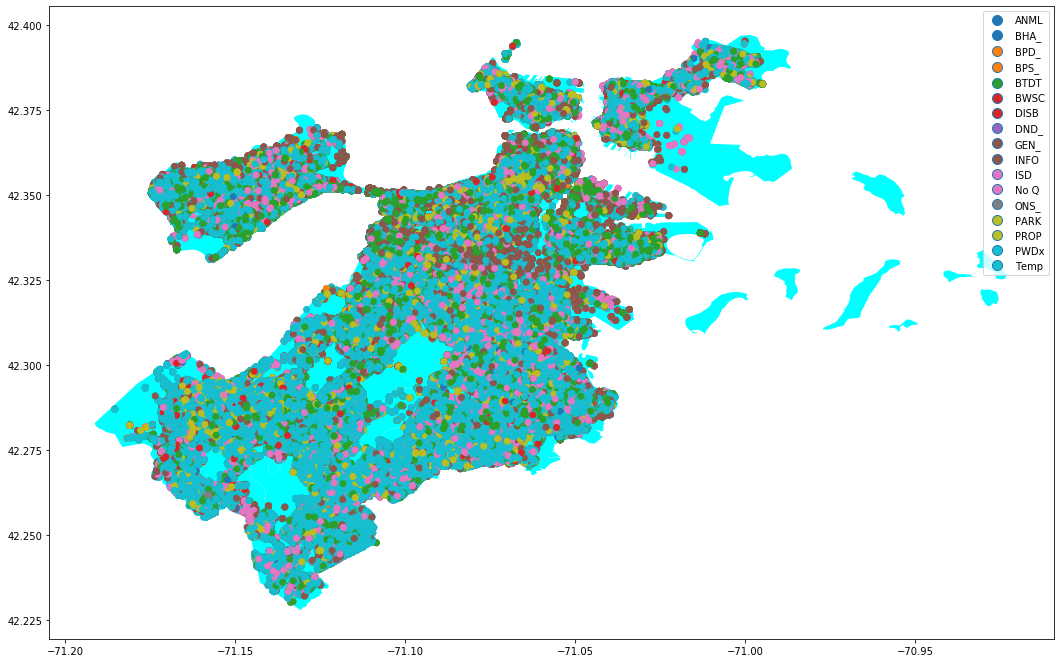

In [4]:
fig, ax = plt.subplots(figsize=(18,16))
nhgp.plot(color='cyan',ax=ax) ;
rawgdf.plot(column='department',legend=True,categorical=True, ax=ax)

To show an example of geospatial data, let us look at the service requests about pests like rats. A complaint is likely to show some sort of a geospatial distribution.

In [5]:
miceRodpest=rawgdf.loc[rawgdf.case_title.str.contains('Mice|Rodent|Pest',na=False)]

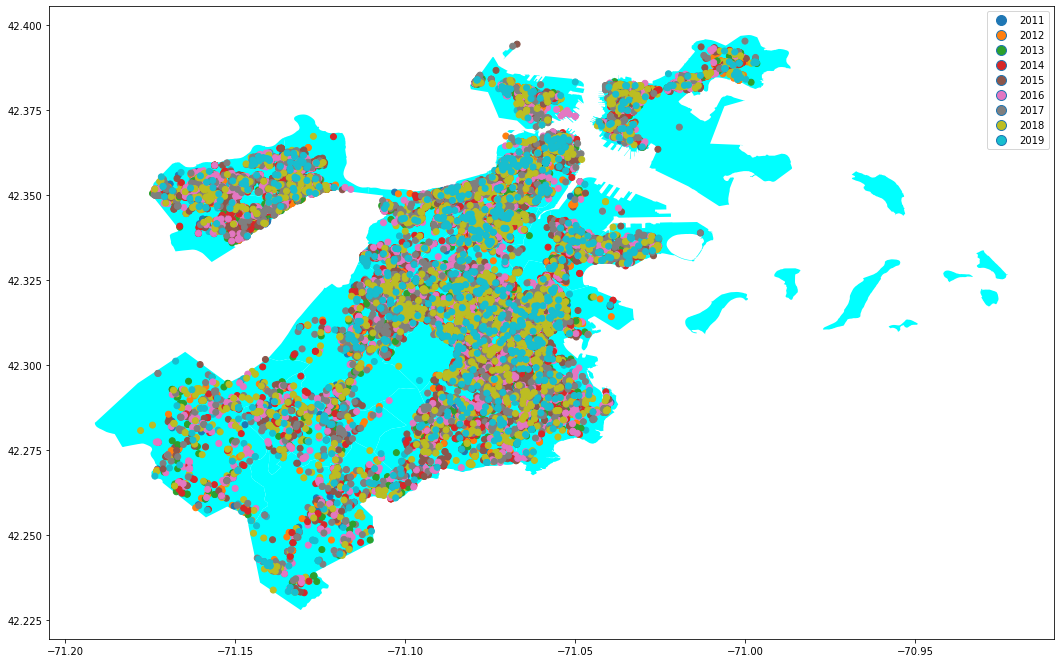

In [8]:
fig, ax = plt.subplots(figsize=(18,16))
nhgp.plot(color='cyan',ax=ax) ;
miceRodpest.plot(column=miceRodpest.open_dt.dt.year,legend=True,categorical=True, ax=ax)

Plotting it as a function of time and months to check if there is a pattern. We observe a periodic pattern over the years. This is evident when we group the data for each month. We notice that the problem exacerbates during the summer months

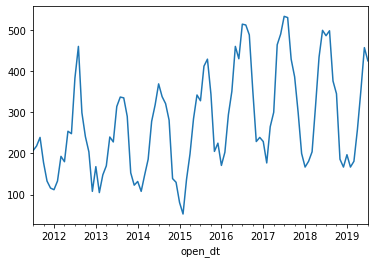

In [6]:
miceRodpest.groupby(pd.Grouper(key='open_dt',freq='M')).size().plot(y='case_title')

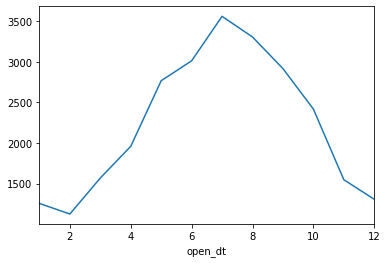

In [7]:
miceRodpest.groupby(by=miceRodpest.open_dt.dt.month).size().plot(y='case_title')

In [9]:
import geoplot as gplt

In [10]:
miceRodpest.crs={'init': 'epsg:4326'}
mRPnames=gpd.sjoin(miceRodpest,nhgp,how='left')

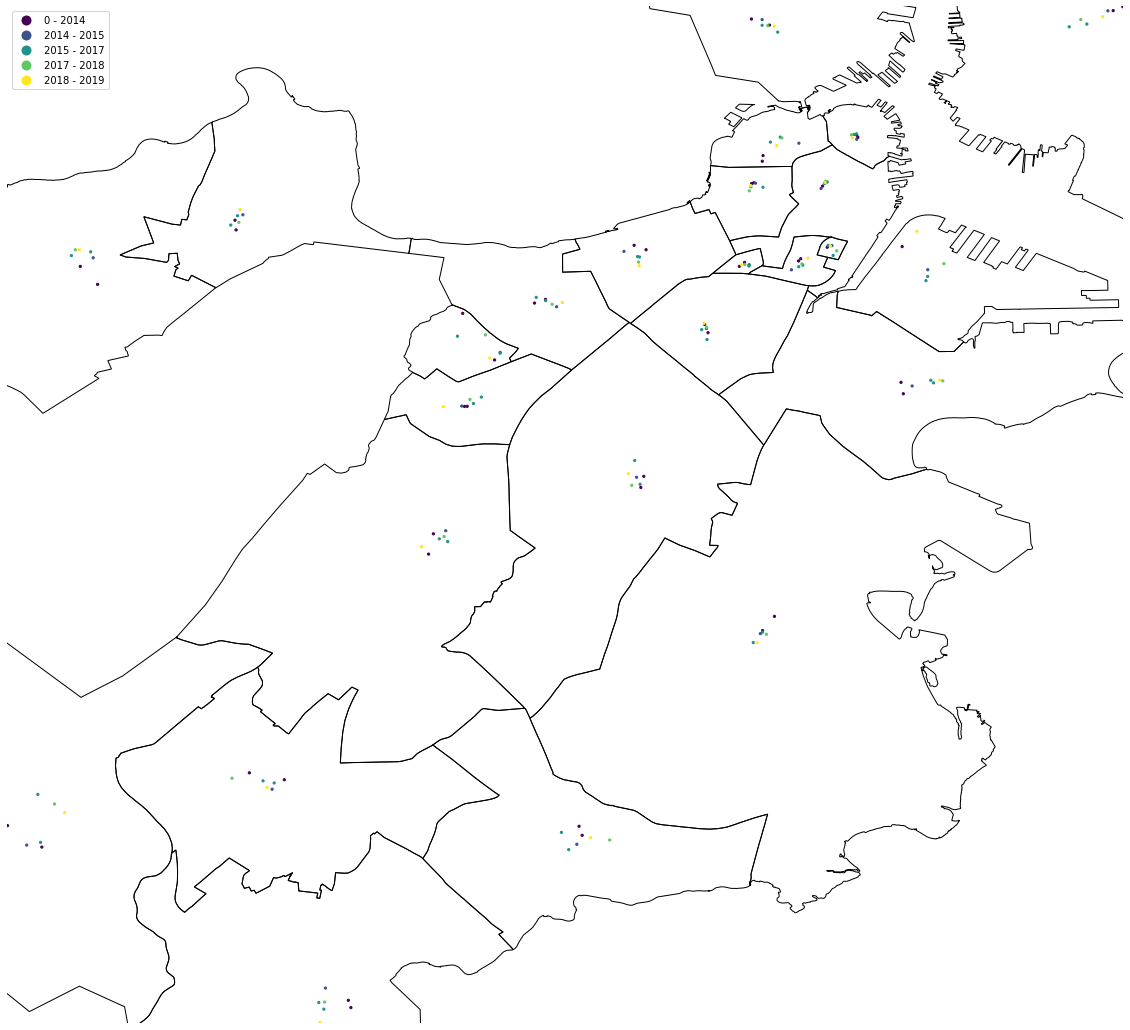

In [51]:
from shapely.geometry import MultiPoint


figsize=(20,20)
ax = gplt.polyplot(nhgp,figsize=figsize)
years=[2013,2014,2015,2016,2017,2018,2019]
cntlist=[]
yearlist=[]

for nb in mRPnames.Name.unique():
    for year in years:
        cntlist.append(MultiPoint(mRPnames[(mRPnames.Name==nb) & (mRPnames.open_dt.dt.year==year)].geometry.tolist()).centroid)
        yearlist.append(year)

#nbs=gpd.GeoDataFrame(data=yearlist,geometry=cntlist,index=pd.DataFrame(index=mRPnames.Name.unique()))
nbs=gpd.GeoDataFrame(data=yearlist,geometry=cntlist)
nbs=nbs[~ nbs.geometry.astype('str').str.contains("EMPTY") ]

gplt.pointplot(nbs,ax=ax,hue=nbs[0],legend=True)
